In [2]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed Aug 31 17:15:06 2022
Driver Version                            : 510.54
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:C4:00.0
    Product Name                          : NVIDIA GeForce RTX 3090
    Product Brand                         : GeForce
    Product Architecture                  : Ampere
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : N/A
    GPU UUID         

In [3]:
import os.path as osp

import torch
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset

import torch_geometric.transforms as T
from torch_geometric.nn import MaskLabel, TransformerConv
from torch_geometric.utils import index_to_mask

In [4]:
import sys
sys.path.insert(0, '..')  #go up one directory
from custom_libraries.my_functions import *

In [5]:
!pwd

/ssl-jet-vol/semi-supervised-tests/Jupyter


In [6]:
root = "/ssl-jet-vol/semi-supervised-tests/Jupyter/data/OGB"
dataset = PygNodePropPredDataset('ogbn-arxiv', root, T.ToUndirected())
dataset

PygNodePropPredDataset()

In [7]:
class UniMP(torch.nn.Module):   #UniMP stands for Unified Message Passing
    def __init__(self, in_channels, num_classes, hidden_channels, num_layers,
                 heads, dropout=0.3):
        super().__init__()

        self.label_emb = MaskLabel(num_classes, in_channels)

        self.convs = torch.nn.ModuleList()  # initialize self.convs
        self.norms = torch.nn.ModuleList()  # initialize self.norms
        for i in range(1, num_layers + 1):
            if i < num_layers:
                out_channels = hidden_channels // heads #what is a head?
                concat = True   #what does concat do?
            else:
                out_channels = num_classes
                concat = False
            conv = TransformerConv(in_channels, out_channels, heads,
                                   concat=concat, beta=True, dropout=dropout)
            self.convs.append(conv)
            in_channels = hidden_channels

            if i < num_layers:
                self.norms.append(torch.nn.LayerNorm(hidden_channels))
                
    def forward(self, x, y, edge_index, label_mask):
        x = self.label_emb(x, y, label_mask)  #mask some of the input labels
        for conv, norm in zip(self.convs, self.norms):
            x = norm(conv(x, edge_index)).relu()
        # conv -> norm -> ReLu -> conv -> norm -> Relu -> ... -> out
        return self.convs[-1](x, edge_index)

## Questions:  

### 2. What does emb stand for?  
Embedding

### 3. What are normalization layers?  what do they do and why do we need them?
https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html  
Normalization? but why?

### 3.1 What are heads?  

### 4. What does concat do?  
If set to False, the multi-head attentions are averaged instead of concatenated. (default: True)  

### 4.1 What are attentions?  

### 7. Why a separate if statement for self.norms?


### 8. What does each parameter mean in this function?  
x: input?  
y: output?  
edge_index: how the graph is connected  
label_mask: 

### 8.1 What does the first line do?  

In [8]:
"""
def forward(self, x: Tensor, y: Tensor, mask: Tensor) -> Tensor:  
        """"""  
        if self.method == "concat":  
            out = x.new_zeros(y.size(0), self.emb.weight.size(-1))  
            out[mask] = self.emb(y[mask])  
            return torch.cat([x, out], dim=-1)  
        else:  
            x = torch.clone(x)  
            x[mask] += self.emb(y[mask])  
            return x
"""

'\ndef forward(self, x: Tensor, y: Tensor, mask: Tensor) -> Tensor:  \n          \n        if self.method == "concat":  \n            out = x.new_zeros(y.size(0), self.emb.weight.size(-1))  \n            out[mask] = self.emb(y[mask])  \n            return torch.cat([x, out], dim=-1)  \n        else:  \n            x = torch.clone(x)  \n            x[mask] += self.emb(y[mask])  \n            return x\n'

I assume this applies the mask to the inputs x but why does this process involve y?  

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
data.y = data.y.view(-1)
model = UniMP(dataset.num_features, dataset.num_classes, hidden_channels=64,
              num_layers=3, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
 
split_idx = dataset.get_idx_split()   # train/val/test split
train_mask = index_to_mask(split_idx['train'], size=data.num_nodes)
val_mask = index_to_mask(split_idx['valid'], size=data.num_nodes)
test_mask = index_to_mask(split_idx['test'], size=data.num_nodes)

### 10. What is weight_decay?  
L2 penalty  
https://swamp-father-f58.notion.site/2-3-Lecture-Dealing-with-Overfitting-f1a77a6d12f445698e4d8cb340300d88

### 12. What does the mask do?  
They mask some of the labels, preventing the nodes from accessing those labels during training/validation/testing



In [10]:
def train(label_rate=0.65):  # How many labels to use for propagation.
    model.train()

    propagation_mask = MaskLabel.ratio_mask(train_mask, ratio=label_rate)
    # Randomly modifies mask by setting a certain ratio (label_rate) of True entries to False
    supervision_mask = train_mask ^ propagation_mask  # Exclusive or: Sets each bit to 1 if only one of two bits is 1
#     print("train_mask:", train_mask)
#     print("propagation_mask:", propagation_mask)
#     print("supervision_mask:", supervision_mask)

    # how to implement mini-batch gradient descent here? Right now going through the data set all at once, taking up too much memory
    optimizer.zero_grad()
    out = model(data.x, data.y, data.edge_index, propagation_mask)  #forward is called
    loss = F.cross_entropy(out[supervision_mask], data.y[supervision_mask])
    loss.backward()
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()

    # evaluation
    propagation_mask = train_mask  #no masked nodes while testing
    out = model(data.x, data.y, data.edge_index, propagation_mask)  # forward is called
    pred = out[val_mask].argmax(dim=-1)  #indices of maximum values across the last dimension
    val_acc = int((pred == data.y[val_mask]).sum()) / pred.size(0)  # Validation accuracy
#     print("out:", out)
#     print("out dim:", out.size())
#     print("out[val_mask] dim:", out[val_mask].size())
#     print("out[test_mask] size:", out[test_mask].size())
#     print("out[train_mask] size:", out[train_mask].size())
#     print("out summed over dimension 1", torch.sum(out, dim=1))
# #     print("out[val_mask]:", out[val_mask])
#     print("eval pred:", pred)
#     print("labels:", data.y[val_mask])
#     print("pred size:",pred.size())
#     print("data.y[val_mask] size:", data.y[val_mask].size())

    # testing
    propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[test_mask].argmax(dim=-1)
    test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)
#     print("test pred", pred)
    
#     print("labels:", data.y[test_mask])

    return val_acc, test_acc

# Summary
out is a torch tensor of dimension [169343, 40].  
out[val_mask] is a torch tensor of dimension [29799, 40].  
This ratio 0.1759683 should be one of the three numbers in the train/val/test split.  
This is confirmed by   
out[val_mask] dim: torch.Size([29799, 40])  
out[test_mask] size: torch.Size([48603, 40])  
out[train_mask] size: torch.Size([90941, 40])  
(The three numbers add up to out.size(0))  

(during evaluation) pred is a torch tensor of dimension [29799]  
It is the indices of maximum values across the second dimension of out[val_mask]

I am assuming each of the 40 numbers is some sort of probability of classifying a data point into a certain category. **But they are negative and do not sum to 1. How to interpret these?**   

Apply softmax to the results to obtain probabilities.
This way, pred then consists of the predictions of the model (which category does a certain data point fall into)

### 13. What is propagation_mask?  
decides which nodes to use for message passing
### 13.1 What is supervision_mask?  
decides which nodes to use for verifying predictions  
(propagation + supervision = training)

## 14. What is argmax(dim=-1)
Returns the indices of the maximum values of a tensor across a dimension.
https://pytorch.org/docs/stable/generated/torch.argmax.html

finding the argument that gives the max value across the last dimension, which is 40.  
But now what does the 40 represent?  
40 categories

In [11]:
def reset_params(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()

In [12]:
reset_params(model)

label_rate = 0.65
num_epochs = 100
loss_lst, val_acc_lst, test_acc_lst = [], [], []

for epoch in range(1, num_epochs+1):
    loss = train(label_rate = label_rate)
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
    loss_lst.append(loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)

Epoch: 001, Loss: 3.6915, Val: 0.1641, Test: 0.1834
Epoch: 002, Loss: 3.5769, Val: 0.3928, Test: 0.4312
Epoch: 003, Loss: 3.4839, Val: 0.4150, Test: 0.4491
Epoch: 004, Loss: 3.4081, Val: 0.4208, Test: 0.4559
Epoch: 005, Loss: 3.3362, Val: 0.4357, Test: 0.4708
Epoch: 006, Loss: 3.2734, Val: 0.4506, Test: 0.4853
Epoch: 007, Loss: 3.2124, Val: 0.4687, Test: 0.5000
Epoch: 008, Loss: 3.1562, Val: 0.4951, Test: 0.5271
Epoch: 009, Loss: 3.1040, Val: 0.5187, Test: 0.5509
Epoch: 010, Loss: 3.0538, Val: 0.5346, Test: 0.5657
Epoch: 011, Loss: 3.0065, Val: 0.5470, Test: 0.5774
Epoch: 012, Loss: 2.9587, Val: 0.5581, Test: 0.5873
Epoch: 013, Loss: 2.9120, Val: 0.5677, Test: 0.5972
Epoch: 014, Loss: 2.8653, Val: 0.5754, Test: 0.6037
Epoch: 015, Loss: 2.8221, Val: 0.5819, Test: 0.6106
Epoch: 016, Loss: 2.7772, Val: 0.5900, Test: 0.6169
Epoch: 017, Loss: 2.7323, Val: 0.5965, Test: 0.6225
Epoch: 018, Loss: 2.6902, Val: 0.6028, Test: 0.6264
Epoch: 019, Loss: 2.6450, Val: 0.6082, Test: 0.6292
Epoch: 020, 

In [13]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

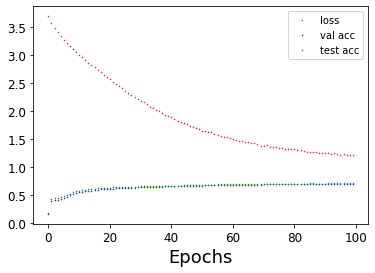

In [14]:
marker_size = 1
plt.plot(loss_lst, "r.", markersize=marker_size, label="loss")
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

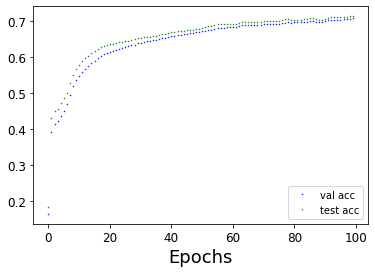

In [15]:
marker_size = 1
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

In [16]:
print("best val epoch:", torch.Tensor(val_acc_lst).argmax())
print("best test epoch:", torch.Tensor(test_acc_lst).argmax())
print("best val acc:", torch.Tensor(val_acc_lst).max())
print("best test acc:", torch.Tensor(test_acc_lst).max())

best val epoch: tensor(99)
best test epoch: tensor(99)
best val acc: tensor(0.7068)
best test acc: tensor(0.7129)


# Optimize label_rate

In [17]:
import numpy as np
label_rate_arr = np.linspace(0.0, 1.0, num=21)

In [18]:
def optimization_loop(label_rate):
    reset_params(model)
    num_epochs = 300
    loss_lst, val_acc_lst, test_acc_lst = [], [], []

    print(f'Label_rate: {label_rate}')
    for epoch in range(1, num_epochs+1):
        loss = train(label_rate = label_rate)
        val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, '
              f'Test: {test_acc:.4f}')
        loss_lst.append(loss)
        val_acc_lst.append(val_acc)
        test_acc_lst.append(test_acc)
    return loss_lst, val_acc_lst, test_acc_lst

In [19]:
# best_val_acc_lst, best_val_epoch_lst, best_test_acc_lst, best_test_epoch_lst = [], [], [], []
# for lr in label_rate_arr:
#     print(lr)
#     lost_lst, val_acc_lst, test_acc_lst = optimization_loop(lr)
    
#     best_val_epoch_lst.append(torch.Tensor(val_acc_lst).argmax())
#     best_val_acc_lst.append(torch.Tensor(val_acc_lst).max())
#     best_test_epoch_lst.append(torch.Tensor(test_acc_lst).argmax())
#     best_test_acc_lst.append(torch.Tensor(test_acc_lst).max())

In [20]:


# marker_size = 3
# fig, axs = plt.subplots(2, 2)
# axs[0, 0].plot(best_val_epoch_lst, "b.", markersize=marker_size)
# axs[0, 0].set_title("best val epoch")


# axs[0, 1].plot(best_val_acc_lst, "b.",markersize=marker_size)
# axs[0, 1].set_title("best val acc")

# axs[1, 0].plot(best_test_epoch_lst, "b.",markersize=marker_size)
# axs[1, 0].set_title("best test epoch")

# axs[1, 1].plot(best_test_acc_lst, "b.",markersize=marker_size)
# axs[1, 1].set_title("best test acc")

# plt.show()

## Try to plot the ROC curve
y-axis: true positive rate = test_acc  
x-axis: false positive rate

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [22]:
propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
out = model(data.x, data.y, data.edge_index, propagation_mask)
pred = out[test_mask].argmax(dim=-1)
test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)

In [23]:
0 in pred

True

In [24]:
out.size()

torch.Size([169343, 40])

In [25]:
m = torch.nn.Softmax(dim=1)
out_norm = m(out)

In [26]:
out_norm[test_mask].size()

torch.Size([48603, 40])

In [27]:
classes = np.array([i for i in range(10)])
out_norm[test_mask][:, classes].size()

torch.Size([48603, 10])

In [28]:
out_norm[test_mask][:, 0].type()

'torch.cuda.FloatTensor'

In [29]:
out_norm[test_mask][:, 0].type() == 'torch.cuda.FloatTensor'

True

In [30]:
data.y[test_mask].size()
# y_real = [1 if y == 1 else 0 for y in data.y[test_mask]]

torch.Size([48603])

In [31]:
assert data.y[test_mask].size() == out_norm[test_mask][:, 0].size()

In [32]:
classes = np.array([i for i in range(40)])
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

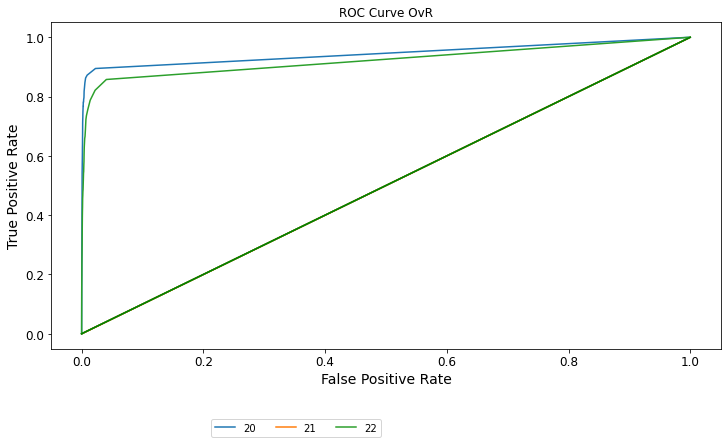

In [33]:
classes = np.array([i for i in range(20, 23)])
plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], ncol=5)

### Plot number of data points for each label

In [34]:
data.y[train_mask]
labels_arr = data.y[train_mask].cpu().numpy()

In [35]:
data.y[train_mask].type()

'torch.cuda.LongTensor'

In [36]:
# List of keys
classes = np.array([i for i in range(40)])
  
# initialize dictionary
d = {}

# iterating through the elements of list
for i in classes:
    d[i] = 0

In [37]:
for data_pt in labels_arr:
    d[data_pt] += 1
d

{0: 437,
 1: 382,
 2: 3604,
 3: 1014,
 4: 2864,
 5: 2933,
 6: 703,
 7: 380,
 8: 4056,
 9: 2245,
 10: 5182,
 11: 391,
 12: 21,
 13: 1290,
 14: 473,
 15: 248,
 16: 9998,
 17: 202,
 18: 402,
 19: 1873,
 20: 1495,
 21: 304,
 22: 1268,
 23: 1539,
 24: 6989,
 25: 457,
 26: 2854,
 27: 1661,
 28: 16284,
 29: 239,
 30: 4334,
 31: 1350,
 32: 270,
 33: 926,
 34: 5426,
 35: 75,
 36: 2506,
 37: 1615,
 38: 1100,
 39: 1551}

In [38]:
list(d.values())

[437,
 382,
 3604,
 1014,
 2864,
 2933,
 703,
 380,
 4056,
 2245,
 5182,
 391,
 21,
 1290,
 473,
 248,
 9998,
 202,
 402,
 1873,
 1495,
 304,
 1268,
 1539,
 6989,
 457,
 2854,
 1661,
 16284,
 239,
 4334,
 1350,
 270,
 926,
 5426,
 75,
 2506,
 1615,
 1100,
 1551]

<BarContainer object of 40 artists>

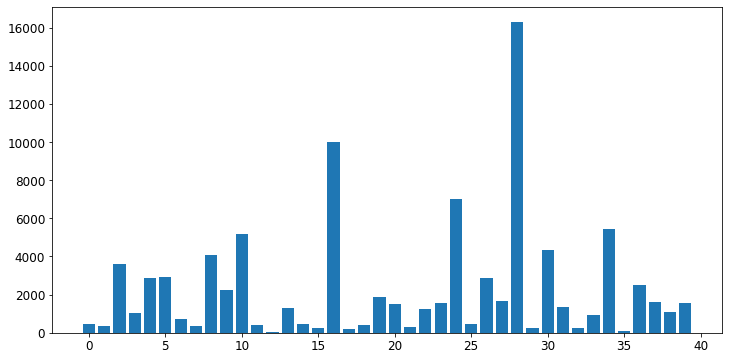

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(d.keys()), list(d.values()))

### Plot accuracy of predictions for each class

In [42]:
pred.size()

torch.Size([48603])

In [126]:
data.y[test_mask].type()  #labels

'torch.cuda.LongTensor'

In [49]:
labels = data.y[test_mask].cpu().numpy()

In [51]:
labels[1]

10

In [64]:
dict = {i: [0, 0] for i in classes}
# dict

In [67]:
dict[1][0] -= 1

In [69]:
# dict

In [71]:
for i in range(pred.size()[0]):
    c = labels[i] # the true class
    dict[c][0] += 1 # the first element is the number of data points
    if c == pred[i]:
        dict[c][1] += 1  # if the prediction matches the label, add 1 to the number of correctly predicted datapoints

In [72]:
dict

{0: [54, 8],
 1: [187, 4],
 2: [733, 496],
 3: [654, 39],
 4: [1869, 1281],
 5: [1246, 653],
 6: [622, 90],
 7: [134, 0],
 8: [1250, 812],
 9: [345, 184],
 10: [1455, 592],
 11: [239, 0],
 12: [5, 0],
 13: [628, 250],
 14: [71, 59],
 15: [87, 1],
 16: [10477, 9730],
 17: [203, 0],
 18: [209, 72],
 19: [419, 264],
 20: [313, 239],
 21: [51, 0],
 22: [386, 218],
 23: [808, 515],
 24: [10740, 7577],
 25: [475, 167],
 26: [1041, 695],
 27: [2066, 1406],
 28: [2849, 2509],
 29: [120, 0],
 30: [4631, 4293],
 31: [892, 402],
 32: [83, 3],
 33: [220, 112],
 34: [1414, 1012],
 35: [36, 0],
 36: [627, 448],
 37: [481, 298],
 38: [214, 158],
 39: [269, 62]}

Check whether the above makes sense

In [77]:
total, correct = 0, 0
for elem in dict.values():
    total += elem[0]
    correct += elem[1]

correct/total == test_acc

True

In [73]:
acc_lst = [elem[1] / elem[0] for elem in dict.values()]
acc_lst

[0.14814814814814814,
 0.0213903743315508,
 0.6766712141882674,
 0.05963302752293578,
 0.6853932584269663,
 0.5240770465489567,
 0.14469453376205788,
 0.0,
 0.6496,
 0.5333333333333333,
 0.406872852233677,
 0.0,
 0.0,
 0.3980891719745223,
 0.8309859154929577,
 0.011494252873563218,
 0.9287009640164169,
 0.0,
 0.3444976076555024,
 0.630071599045346,
 0.7635782747603834,
 0.0,
 0.5647668393782384,
 0.6373762376237624,
 0.7054934823091248,
 0.35157894736842105,
 0.6676272814601345,
 0.68054211035818,
 0.8806598806598807,
 0.0,
 0.927013603973224,
 0.45067264573991034,
 0.03614457831325301,
 0.509090909090909,
 0.7157001414427157,
 0.0,
 0.7145135566188198,
 0.6195426195426196,
 0.7383177570093458,
 0.23048327137546468]

<BarContainer object of 40 artists>

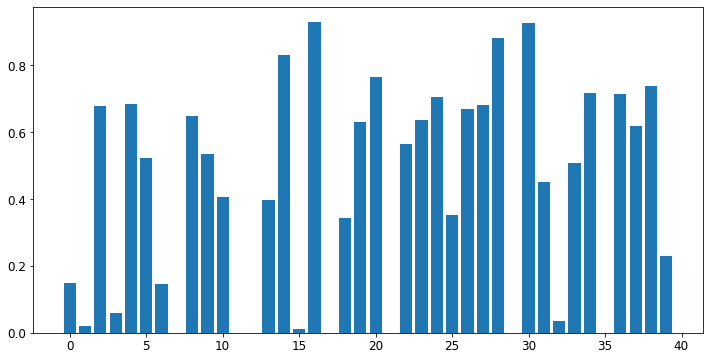

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(d.keys()), acc_lst)

In [93]:
data_tuples = list(zip(list(d.values()), acc_lst))
data_tuples

[(437, 0.14814814814814814),
 (382, 0.0213903743315508),
 (3604, 0.6766712141882674),
 (1014, 0.05963302752293578),
 (2864, 0.6853932584269663),
 (2933, 0.5240770465489567),
 (703, 0.14469453376205788),
 (380, 0.0),
 (4056, 0.6496),
 (2245, 0.5333333333333333),
 (5182, 0.406872852233677),
 (391, 0.0),
 (21, 0.0),
 (1290, 0.3980891719745223),
 (473, 0.8309859154929577),
 (248, 0.011494252873563218),
 (9998, 0.9287009640164169),
 (202, 0.0),
 (402, 0.3444976076555024),
 (1873, 0.630071599045346),
 (1495, 0.7635782747603834),
 (304, 0.0),
 (1268, 0.5647668393782384),
 (1539, 0.6373762376237624),
 (6989, 0.7054934823091248),
 (457, 0.35157894736842105),
 (2854, 0.6676272814601345),
 (1661, 0.68054211035818),
 (16284, 0.8806598806598807),
 (239, 0.0),
 (4334, 0.927013603973224),
 (1350, 0.45067264573991034),
 (270, 0.03614457831325301),
 (926, 0.509090909090909),
 (5426, 0.7157001414427157),
 (75, 0.0),
 (2506, 0.7145135566188198),
 (1615, 0.6195426195426196),
 (1100, 0.7383177570093458),
 

In [95]:
df = pd.DataFrame(data_tuples, columns=['# of data points', "Accuracy"])
df

,# of data points,Accuracy
0,437,0.148148
1,382,0.021390
2,3604,0.676671
3,1014,0.059633
4,2864,0.685393
5,2933,0.524077
6,703,0.144695
7,380,0.000000
8,4056,0.649600
9,2245,0.533333


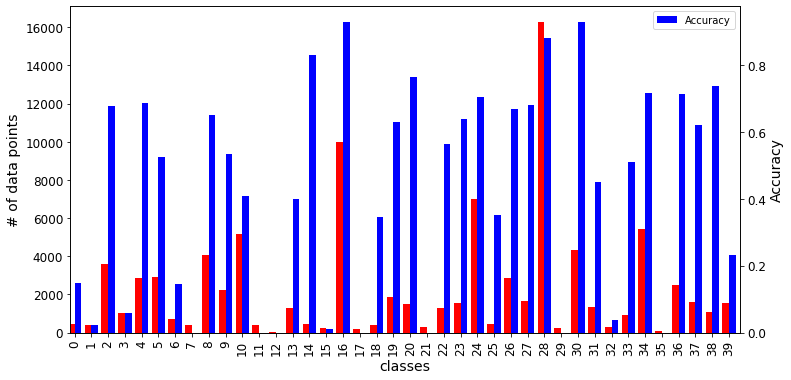

In [105]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df['# of data points'].plot(kind='bar', color='red', ax=ax, width=width, position=1, label='# of data points')
df["Accuracy"].plot(kind='bar', color='blue', ax=ax2, width=width, position=0, label="Accuracy")

ax.set_xlabel('classes')
ax.set_ylabel('# of data points')
ax2.set_ylabel("Accuracy")
plt.legend()
plt.show()

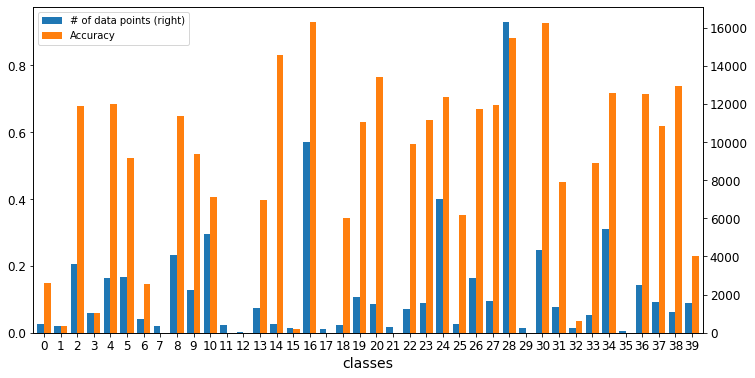

In [111]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.8
_ = df.plot(kind= 'bar' , secondary_y= '# of data points' ,width=width, ax=ax, rot= 0)
ax.set_xlabel('classes')
plt.show()

In [ ]:
def plot_class_balance_and_accuracy(classes, labels, predictions):
    '''
    Plots a bar graph of the # of data points AND the accuracy for each class 
    
    Args:
        classes: list of classes. Accepted datatypes: numpy list, python list
        labels: list of labels. Accepted datatypes: numpy list, python list
        predictions: The list of predicted classes.
    '''
    if predictions.type() == 'torch.cuda.FloatTensor' or 'torch.cuda.LongTensor':
        predictions = predictions.cpu()
        
    if ax == None:
        fig, ax = plt.subplots(figsize=(9, 9))

### Calculate and plot AUC for each class

In [116]:
def plot_overlayed_roc_curve(classes, labels, predictions, ax = None, figsize=(9, 9), ncol=2):
    '''
    Plots overlayed ROC curves and returns a list of AUC.
    
    Args:
        classes: The classes used in classification
        labels: The list of labels.
        predictions: The list of predicted classes. First dimension should match with the dimension of labels
    Return:
        roc_auc_ovr: Dictionary of AUC, one for each class
    '''
    assert labels.size() == predictions[:, 0].size()
    if predictions.type() == 'torch.cuda.FloatTensor':
        predictions = predictions.cpu()
        
    if ax == None:
        fig, ax = plt.subplots(figsize=(9, 9))
    
    roc_auc_ovr = {}
    for i in range(len(classes)):
        c = classes[i]
        y_real = [1 if y == c else 0 for y in labels]
        y_proba = predictions[:, i]
        tpr, fpr = get_all_roc_coordinates(y_real, y_proba)
        ax.plot(fpr, tpr, label = c)
        
        # Calculates the ROC AUC
        roc_auc_ovr[c] = roc_auc_score(y_real, y_proba.detach())
        print(roc_auc_ovr[c])

    x = np.linspace(0, 1, 10)
    Y = x
    plt.plot(x, Y, color='g')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    ax.legend(loc='best', bbox_to_anchor=(0.5, -0.20), shadow=False, ncol=ncol)
    plt.title("ROC Curve OvR")
    plt.show()
    
    return roc_auc_ovr

0.9024738656553937
0.8015981590917928
0.9869220042572098
0.8121560478089519
0.960331473576889
0.9405935978046742
0.7789743072870954
0.8477130943520447
0.9676967203767449
0.983003914346859
0.8805496153517606
0.7886283981757586
0.8354294415408042
0.918813142460743
0.9674763739446487
0.9378816136494371
0.9753840519390022
0.7065263811423685
0.9620754520361474
0.9516949149184293
0.9686048811857542
0.7493425282454389
0.9738367060571695
0.9489242422516129
0.9270978639986531
0.9569212363521836
0.9599383923611955
0.9622678992936555
0.9906324700441062
0.8544912649794774
0.986014160912709
0.9398587280875427
0.9520036452487609
0.9707557876263827
0.9793378506240352
0.7597351196399933
0.9663006343682209
0.960924593857556
0.9658443652618198
0.9512926087572487


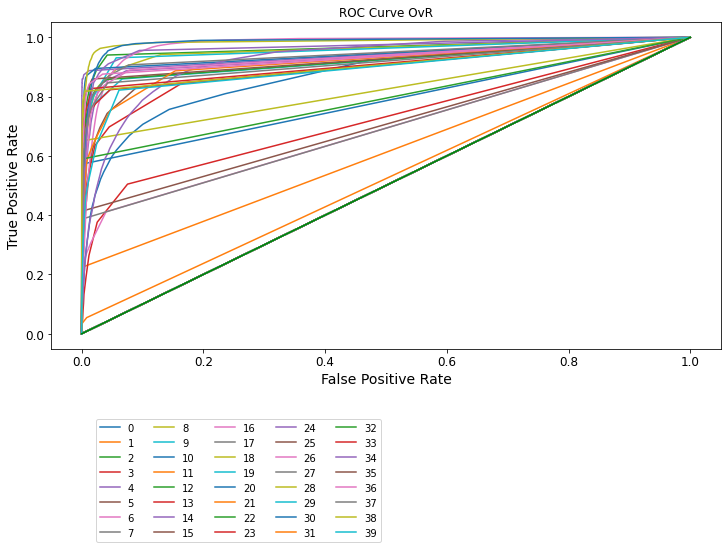

In [117]:
classes = np.array([i for i in range(40)])
roc_auc_ovr = plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], ncol=5)

<BarContainer object of 40 artists>

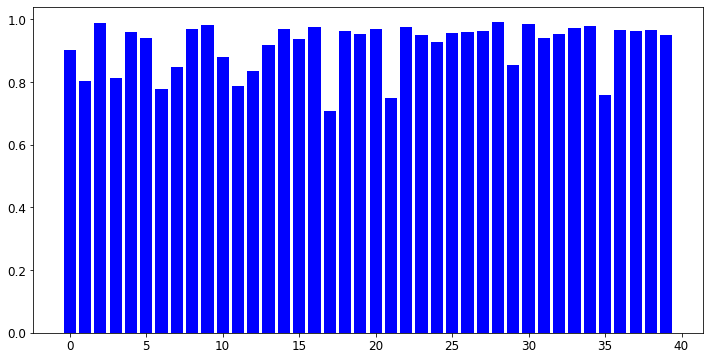

In [118]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(list(roc_auc_ovr.keys()), list(roc_auc_ovr.values()), color='b')

In [121]:
data_tuples = list(zip(list(d.values()), list(roc_auc_ovr.values())))
data_tuples

[(437, 0.9024738656553937),
 (382, 0.8015981590917928),
 (3604, 0.9869220042572098),
 (1014, 0.8121560478089519),
 (2864, 0.960331473576889),
 (2933, 0.9405935978046742),
 (703, 0.7789743072870954),
 (380, 0.8477130943520447),
 (4056, 0.9676967203767449),
 (2245, 0.983003914346859),
 (5182, 0.8805496153517606),
 (391, 0.7886283981757586),
 (21, 0.8354294415408042),
 (1290, 0.918813142460743),
 (473, 0.9674763739446487),
 (248, 0.9378816136494371),
 (9998, 0.9753840519390022),
 (202, 0.7065263811423685),
 (402, 0.9620754520361474),
 (1873, 0.9516949149184293),
 (1495, 0.9686048811857542),
 (304, 0.7493425282454389),
 (1268, 0.9738367060571695),
 (1539, 0.9489242422516129),
 (6989, 0.9270978639986531),
 (457, 0.9569212363521836),
 (2854, 0.9599383923611955),
 (1661, 0.9622678992936555),
 (16284, 0.9906324700441062),
 (239, 0.8544912649794774),
 (4334, 0.986014160912709),
 (1350, 0.9398587280875427),
 (270, 0.9520036452487609),
 (926, 0.9707557876263827),
 (5426, 0.9793378506240352),
 (75

In [122]:
df = pd.DataFrame(data_tuples, columns=['# of data points', "ROC_AUC"])
df

,# of data points,ROC_AUC
0,437,0.902474
1,382,0.801598
2,3604,0.986922
3,1014,0.812156
4,2864,0.960331
5,2933,0.940594
6,703,0.778974
7,380,0.847713
8,4056,0.967697
9,2245,0.983004


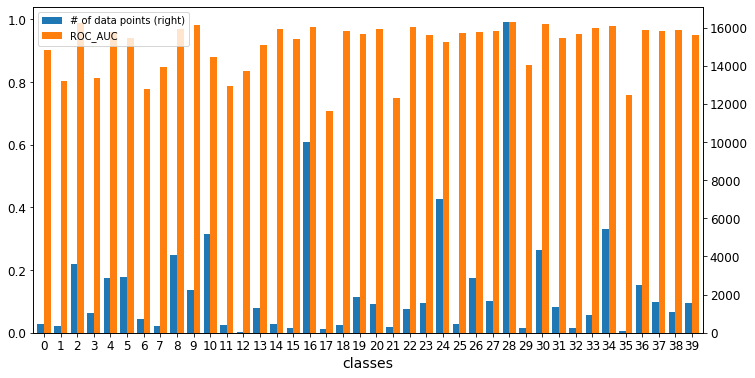

In [123]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.8
_ = df.plot(kind= 'bar' , secondary_y= '# of data points' ,width=width, ax=ax, rot= 0)
ax.set_xlabel('classes')
plt.show()

### Package the above two plots into functions

In [136]:
def plot_class_balance(classes, labels):
    '''
    Plots a bar graph of # of data points for each class
    
    Args:
        classes: list of classes. Accepted datatypes: numpy list, python list
        labels: list of labels. Accepted datatypes: numpy list, python list
    Return:
        d: dictionary of number of data points for each class
    '''
    # initialize dictionary
    d = {i: 0 for i in classes}

    for data in labels:
        d[data] += 1
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(list(d.keys()), list(d.values()))
#     print(d)
    return d

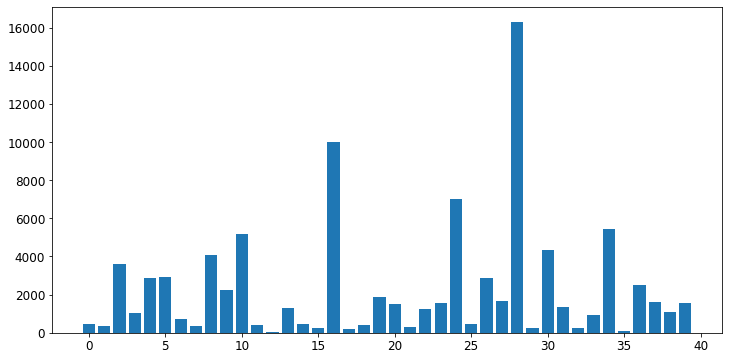

In [161]:
classes = np.array([i for i in range(40)])
labels_arr = data.y[train_mask].cpu().numpy()
class_dict = plot_class_balance(classes, labels_arr)

In [162]:
class_dict

{0: 437,
 1: 382,
 2: 3604,
 3: 1014,
 4: 2864,
 5: 2933,
 6: 703,
 7: 380,
 8: 4056,
 9: 2245,
 10: 5182,
 11: 391,
 12: 21,
 13: 1290,
 14: 473,
 15: 248,
 16: 9998,
 17: 202,
 18: 402,
 19: 1873,
 20: 1495,
 21: 304,
 22: 1268,
 23: 1539,
 24: 6989,
 25: 457,
 26: 2854,
 27: 1661,
 28: 16284,
 29: 239,
 30: 4334,
 31: 1350,
 32: 270,
 33: 926,
 34: 5426,
 35: 75,
 36: 2506,
 37: 1615,
 38: 1100,
 39: 1551}

In [163]:
def plot_class_balance_and_accuracy(class_dict, classes, labels, predictions, width=0.8):
    '''
    Plots two bar graphs:
        a bar graph of accuracy for each class
        a bar graph of the # of data points AND the accuracy for each class
    
    Args:
        class_dict: dictionary of number of data points for each class. Can be obtained by calling plot_class_balance
        classes: list of classes. Accepted datatypes: numpy list, python list
        labels: list of labels. Accepted datatypes: numpy list, python list
        predictions: The list of predicted classes.
        width: width of the bars. Default = 0.8
    '''
    # calcualte the accuracy for each class
    dict = {i: [0, 0] for i in classes}
    for i in range(predictions.size()[0]):
        c = labels[i] # the true class
        dict[c][0] += 1 # the first element is the number of data points
        if c == pred[i]:
            dict[c][1] += 1  # if the prediction matches the label, add 1 to the number of correctly predicted datapoints
    acc_lst = [elem[1] / elem[0] for elem in dict.values()]
    print(dict)
    
    # plot the accuracy
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(classes, acc_lst, color='tab:orange')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Accuracy')
    plt.show()

    # plot the accuracy and # of data points per class
    data_tuples = list(zip(list(class_dict.values()), acc_lst))
    df = pd.DataFrame(data_tuples, columns=['# of data points', 'Accuracy'])

    fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    width = width
    _ = df.plot(kind= 'bar' , secondary_y= '# of data points' ,width=width, ax=ax, rot= 0)
    ax.set_xlabel('Classes')
    plt.show()

{0: [54, 8], 1: [187, 4], 2: [733, 496], 3: [654, 39], 4: [1869, 1281], 5: [1246, 653], 6: [622, 90], 7: [134, 0], 8: [1250, 812], 9: [345, 184], 10: [1455, 592], 11: [239, 0], 12: [5, 0], 13: [628, 250], 14: [71, 59], 15: [87, 1], 16: [10477, 9730], 17: [203, 0], 18: [209, 72], 19: [419, 264], 20: [313, 239], 21: [51, 0], 22: [386, 218], 23: [808, 515], 24: [10740, 7577], 25: [475, 167], 26: [1041, 695], 27: [2066, 1406], 28: [2849, 2509], 29: [120, 0], 30: [4631, 4293], 31: [892, 402], 32: [83, 3], 33: [220, 112], 34: [1414, 1012], 35: [36, 0], 36: [627, 448], 37: [481, 298], 38: [214, 158], 39: [269, 62]}


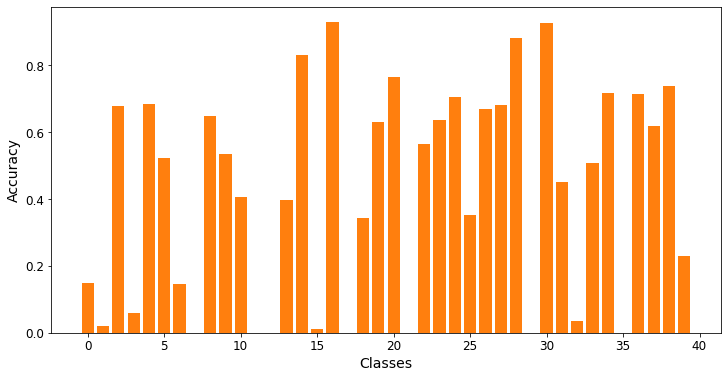

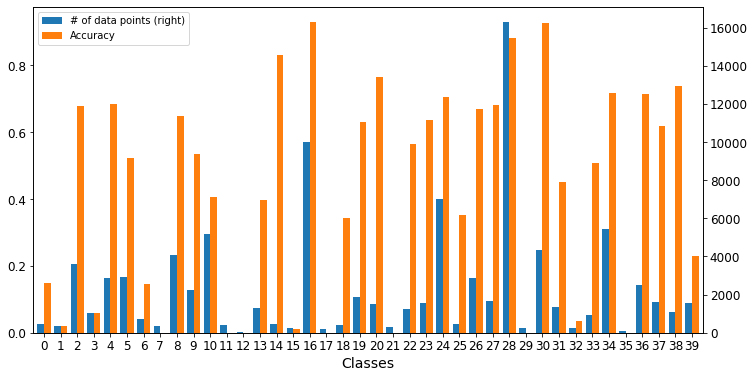

In [164]:
labels_arr = data.y[test_mask].cpu().numpy()
plot_class_balance_and_accuracy(class_dict, classes, labels_arr, pred)